## A Summary of Udacity's A/B Testing Project

### Author: Junyuan Zheng
### Email: jz3036@cumc.columbia.edu

### Source: www.udacity.com
### Background:

### Control:
- At the time of this experiment, Udacity courses currently have two options on the home page: __"start free trial"__, and __"access course materials"__. If the student __clicks "start free trial"__, they will be asked to enter their credit card information, and then they will be __enrolled__ in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

### Experiment:
- In the experiment, Udacity tested a change where if the student __clicked "start free trial"__, they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead.

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time — __without significantly reducing the number of students to continue past the free trial__ and __eventually complete the course__. \
If this hypothesis held true, __Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course__.

The __Unit of Diversion__ is a __cookie__, although if the student enrolls in the free trial, they are tracked by __User Id__ from that point forward. The same User Id cannot enroll in the free trial twice. For users that do not enroll, their User Id is not tracked in the experiment, even if they were signed in when they visited the course overview page.
- __"unique cookies"__: Note the uniqueness is determined by day. (That is, the same cookie visiting on different days would be counted twice.)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# 1 Experiment Design

## 1.1 Metrics

### 1.1.1 Evaluation Metrics

- __Retention__:  The number of UserIds to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of UserIds enrolled to the free trial.

$$
P_{R} = Retention = \dfrac{\text{# of Ids remain enrolled for at least 14 days}}{\text{# of Ids enrolled}}
$$

$$
P_R (baseline) = P_{R0} = 0.53
$$

Minimal meaningful worthwhile effect (in absolute change):
$$
DA_R = 0.01
$$

### 1.1.2 Invariant Metrics

- __Number of cookies__:  The number of unique cookies viewed the course overview page per day.
- __Number of clicks__: The number of unique cookies clicked the "Start free trial" button per day.

- __Click Through Probability__:  The number of unique cookies to click the "start free
trial" button divided by the number of unique cookies to view the course overview page.

$$
P_{CT} = CTP = \dfrac{\text{# of unique cookies viewed the course overview page}}{\text{# of unique cookies clicked the "start free trial" button}}
$$

### 1.1.3 Other Relavent Metrics

- __Number of enrollments__: the number of users who enrolled in the free trial per day.
- __Gross Conversion__: The number of users who enrolled in the free trial divided by the number of unique cookies cliked the "Start free trial" button.

$$
P_{GC} = GrossConversion = \dfrac{\text{# of users who enrolled in the free trial}}{\text{# of unique cookies clicked the "start free trial" button}}
$$

- __Number of payments__: the number of UserIds to remain enrolled past the 14-day boundary (and thus make at least one payment)

- __Net Conversion__: The number of UserIds to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies cliked the "Start free trial" button. 

$$
P_{NC} = Net Conversion = \dfrac{\text{# of ids remain enrolled for at least 14 days}}{\text{# of unique cookies clicked the "start free trial" button}}
$$

- Since part of the effects of the experiment is to somewhat persuade some of the users not to enroll, we would expect these four metrics to go done. \
However, we don't want them to go done too much since that would potentially reduce the income. \
Therefore, we are going to treat GC and NC as a secondery outcome.

## 1.2 Sample Size

With CLT:
$$
n = \dfrac{r+1}{r} \cdot \dfrac{\bar{P}(1-\bar{P})(z_{\beta}+z_{\alpha/2})^2}{(P_1-P_2)^2}
$$

\begin{align}
& n: \text{sample size of larger group} \\
& n/r: \text{sample size of smaller group} \\
& r: \text{ratio of larger group to smaller group} \\
& P_1: \text{P for control group} \\
& P_2: \text{P for experiment group} \\
& \bar{P}: \dfrac{P_1 + P_2}{2} \\
& \alpha: \text{prob. for type I error control} \\
& \beta: \text{prob. for type II error control}
\end{align}

- We will be using an alpha of 0.05 and beta of 0.2.

In [5]:
# function for calculating sample size
from scipy.stats import norm
def sample_size_calculator(r, p1, p2, alpha, beta):
    p_bar = (p1+p2)/2
    z_beta = norm.ppf(1-beta)
    z_alpha2 = norm.ppf(1-alpha/2)
    
    n = ((r+1)/r) * (p_bar*(1-p_bar)*(z_beta+z_alpha2)**2) / (p1-p2)**2
    return n

### 1.2.1 Retention

In [6]:
n_enrolled = np.ceil(sample_size_calculator(1, 0.53, 0.53+0.01, 0.05, 0.2))
n_enrolled

39053.0

- Assuming equal sample sizes for control and experiment group.
- Since the denominator of Retention is __the number of UserIds enrolled to the free trial__, we need about __39053__ enrollments in total for each group to have enough power of detecting the difference.

## 1.3 Duration and Exposure

- From __1.2__, we got approximations of how many events we need for the candidate evaluation metrics, Retention. However, this is not enough. Since the unit of diversion is "unique cookies", which are collected when the cookies viewed the course overview page, we need to convert what we got from __1.2__ to the total number of unique cookies viewed the course overview page needed to evaluate the duration for collecting the data.
- This is done by looking at the so-called __"funnel"__, which gives us a sense of the baseline values of related metrics and their conversion rates through the "funnel".

__The "funnel":__
- The number of unique cookies viewed the course overview page per day: \
__40000__
- The number of unique cookies clicked the "Start free trial" button per day: \
__3200__
- The number of enrollments per day: \
__660__

### 1.3.1 Retention

In [7]:
# The number of unique cookies viewed the course overview page needed for each group
N_cookies_R = np.ceil(n_enrolled * 40000 / 660)
N_cookies_R

2366849.0

In [8]:
# How many days needed to collect the data, given 40000 cookies of page view per day (100% traffic).
N_cookies_R * 2 / 40000

118.34245

- As shown above, we need at least 118 days to collect enough data for detecting the difference in Retention. This is too long of a period for making business decisions.
- Since this is the only metric we expect that could go up, as a practice, we are going to ignore this defect for the time being.

### 1.3.2 Sampling Schedule

In [9]:
N_cookies_R * 2 / 20000

236.6849

- Assume we are going to use __50% of the traffic__, which are 20000 unique cookies viewed the course overview page, it takes about __237 days__ to get the sample we need.
- Note that usually we also won't use this large portion of traffic to just do one test.
- Since we would typically like to sample through at least a whole week, the duration here would be about 237/7= __34 consesutive weeks__.

# 2 Statistical Analysis

In [ ]:
# import results
Data_ctrl = pd.read_excel('./FinalProject_Results.xlsx', sheet_name='Control')
Data_exp = pd.read_excel('./FinalProject_Results.xlsx', sheet_name='Experiment')

In [68]:
Data_ctrl.head(5)

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,GC,NC,R
0,"Sat, Oct 11",7723,687,134.0,70.0,0.088955,0.195051,0.101892,0.522388
1,"Sun, Oct 12",9102,779,147.0,70.0,0.085586,0.188703,0.089859,0.476190
2,"Mon, Oct 13",10511,909,167.0,95.0,0.086481,0.183718,0.104510,0.568862
3,"Tue, Oct 14",9871,836,156.0,105.0,0.084693,0.186603,0.125598,0.673077
4,"Wed, Oct 15",10014,837,163.0,64.0,0.083583,0.194743,0.076464,0.392638


In [69]:
Data_exp.head(5)

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,GC,NC,R
0,"Sat, Oct 11",7716,686,105.0,34.0,0.088906,0.153061,0.049563,0.323810
1,"Sun, Oct 12",9288,785,116.0,91.0,0.084518,0.147771,0.115924,0.784483
2,"Mon, Oct 13",10480,884,145.0,79.0,0.084351,0.164027,0.089367,0.544828
3,"Tue, Oct 14",9867,827,138.0,92.0,0.083815,0.166868,0.111245,0.666667
4,"Wed, Oct 15",9793,832,140.0,94.0,0.084959,0.168269,0.112981,0.671429


- The final sample collected did not reach to what we calculated in __1.3.1__.
- As a practice, we are going to use what we have available to perform further analysis.

## 2.1 Sanity Check

### 2.1.1 Number of cookies collected each day

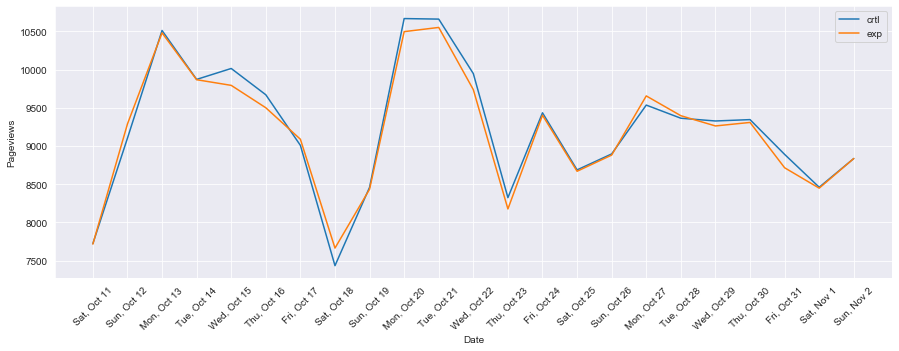

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Pageviews', data=Data_ctrl[Data_ctrl['Enrollments'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='Pageviews', data=Data_exp[Data_ctrl['Enrollments'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

- For this metric, we want to check whether the randomization system worked.
- This is the same to say that whether each unique cookie has an equal chance (0.5) to be allecated to the control or experiment group.
- With enough large sample size, Normal distribution could approximate Binomial.

$$
\text{Under} \ H_0: \ \ \ \hat{n}_C \sim N( \ (n_C+n_T)0.5, \sqrt{(n_C+n_T)0.5(1-0.5)} \ ) 
$$

In [11]:
n_C = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
n_T = Data_exp[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
print ('n_C:',n_C, 'n_T:', n_T)

n_C: 3785.0 n_T: 3423.0


In [12]:
print ( '95% CI:', ((n_C+n_T)*0.5-np.sqrt((n_C+n_T)*0.5*(1-0.5)), (n_C+n_T)*0.5+np.sqrt((n_C+n_T)*0.5*(1-0.5))) )

95% CI: (3561.5500294464177, 3646.4499705535823)


- As shown above, neither the total unique number of cookies collected for the control nor for the experiment group fall into the 95% CI. This means that something is probably going wrong in the randomization procedure.
- In this case, we might want to further talk to the engineer to see where the problem is.

### 2.1.2 Number of clicks recorded

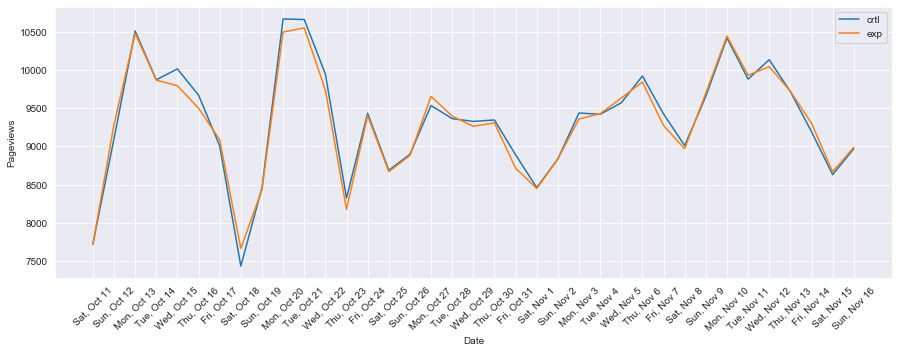

In [13]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Pageviews', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='Pageviews', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

- Give the problem we detected from 2.1.1, there is not much point of checking whether this count metric has no significant difference between control and experiment group.
- Alternatively, we can still chekc the Click Through Probability of the two groups.

### 2.1.3 Click Through Probability

In [14]:
Data_ctrl['CTP'] = Data_ctrl['Clicks'] / Data_ctrl['Pageviews']
Data_exp['CTP'] = Data_exp['Clicks'] / Data_exp['Pageviews']

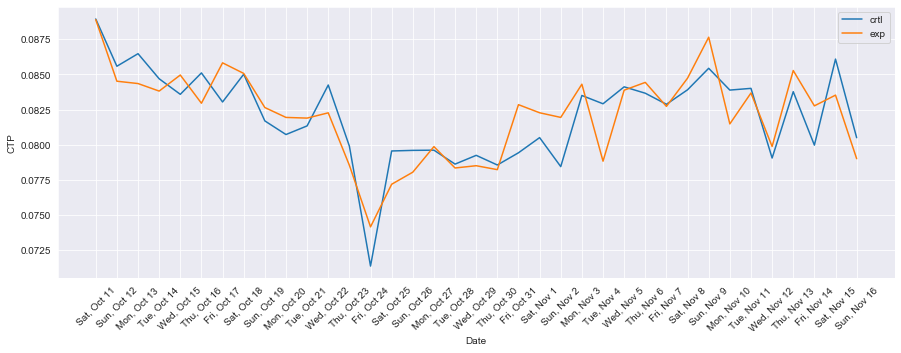

In [15]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='CTP', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='CTP', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

$$
\hat{d} = \hat{P}_{T} - \hat{P}_{C} \\
\hat{P}_C = \dfrac{x_C}{n_C} , \ \hat{P}_T = \dfrac{x_T}{n_T} \\
\ se_{pool} = \sqrt{\hat{P}_{pool}(1-\hat{P}_{pool})(\dfrac{1}{n_C}+\dfrac{1}{n_T})} \\
\hat{P}_{pool} = \dfrac{x_C+x_T}{n_C+n_T} \\
\text{then 95% CI:} \ \ \ \hat{d} \pm 1.96 \cdot se_{pool}
$$

$$
\text{Under} \ H_0: \ \ \ \hat{d}_0 \sim N(0, se_{pool}) 
$$

In [16]:
n_C_CTP = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Pageviews'].sum()
x_C_CTP = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
P_C_CTP = x_C_CTP / n_C_CTP
P_C_CTP

0.0815080857642473

In [17]:
n_T_CTP = Data_exp[Data_ctrl['Enrollments'].notnull()]['Pageviews'].sum()
x_T_CTP = Data_exp[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
P_T_CTP = x_T_CTP / n_T_CTP
P_T_CTP

0.08166084726677454

In [18]:
d_CTP = P_T_CTP - P_C_CTP
d_CTP

0.0001527615025272433

In [19]:
P_pool_CTP = (x_C_CTP + x_T_CTP) / (n_C_CTP + n_T_CTP)
P_pool_CTP

0.08158432205891034

In [20]:
se_pool_CTP = np.sqrt(P_pool_CTP*(1 - P_pool_CTP)*(1/n_C_CTP + 1/n_T_CTP))
se_pool_CTP

0.0008412290191049275

In [21]:
CI_low_CTP = d_CTP - 1.96*se_pool_CTP
CI_high_CTP = d_CTP + 1.96*se_pool_CTP
print ('95% CI:', (CI_low_CTP, CI_high_CTP))

95% CI: (-0.0014960473749184146, 0.0018015703799729012)


- As shown above, the calculated 95% CI contains "0", which means that there is no significant difference between the control and experiment group on the CTP.

### Other Relavent Metrics

### 2.1.4 Number of enrollments: the number of users who enrolled in the free trial per day.

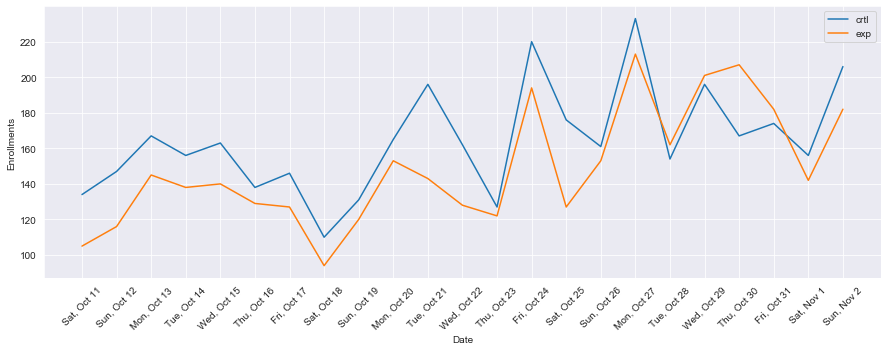

In [22]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Enrollments', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='Enrollments', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

- Give the problem we detected from 2.1.1, there is not much point of checking whether this count metric has no significant difference between control and experiment group.

### 2.1.5 Gross Conversion

In [23]:
Data_ctrl['GC'] = Data_ctrl['Enrollments'] / Data_ctrl['Clicks']
Data_exp['GC'] = Data_exp['Enrollments'] / Data_exp['Clicks']

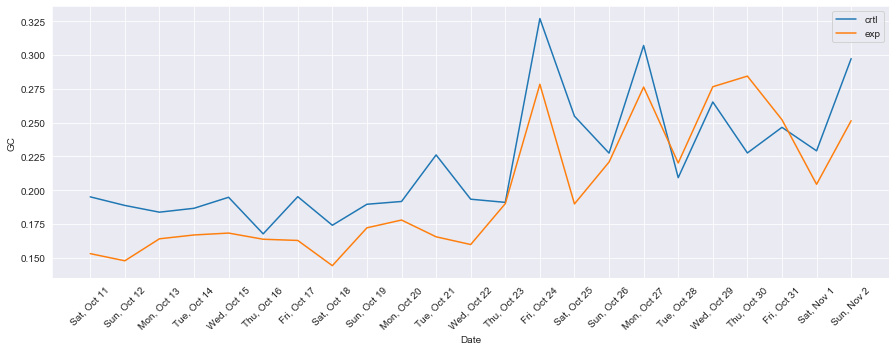

In [24]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='GC', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='GC', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

In [25]:
n_C_GC = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
x_C_GC = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
P_C_GC = x_C_GC / n_C_GC
P_C_GC

0.2188746891805933

In [26]:
n_T_GC = Data_exp[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
x_T_GC = Data_exp[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
P_T_GC = x_T_GC / n_T_GC
P_T_GC

0.19831981460023174

In [27]:
d_GC = P_T_GC - P_C_GC
d_GC

-0.020554874580361565

In [28]:
P_pool_GC = (x_C_GC + x_T_GC) / (n_C_GC + n_T_GC)
P_pool_GC

0.20860706740369866

In [29]:
se_pool_GC = np.sqrt(P_pool_GC*(1 - P_pool_GC)*(1/n_C_GC + 1/n_T_GC))
se_pool_GC

0.004371675385225936

In [30]:
CI_low_GC = d_GC - 1.96*se_pool_GC
CI_high_GC = d_GC + 1.96*se_pool_GC
print ('95% CI:', (CI_low_GC, CI_high_GC))

95% CI: (-0.0291233583354044, -0.01198639082531873)


- As shown above, the 95% CI does not contain "0" and it less than 0, which means that the experiment group has a significant low GC than the control group.
- This result is somewhat we expected since the chance could potential reduce the amount of enrollments.

### 2.1.6 Number of payments

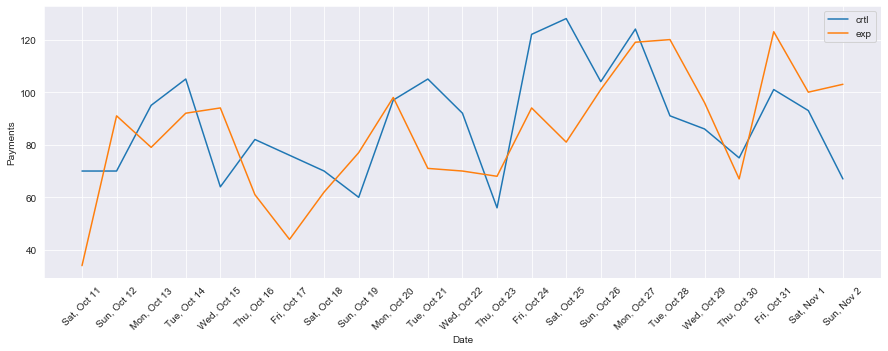

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Payments', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='Payments', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

- Give the problem we detected from 2.1.1, there is not much point of checking whether this count metric has no significant difference between control and experiment group.

### 2.1.7 Net Conversion 

In [32]:
Data_ctrl['NC'] = Data_ctrl['Payments'] / Data_ctrl['Clicks']
Data_exp['NC'] = Data_exp['Payments'] / Data_exp['Clicks']

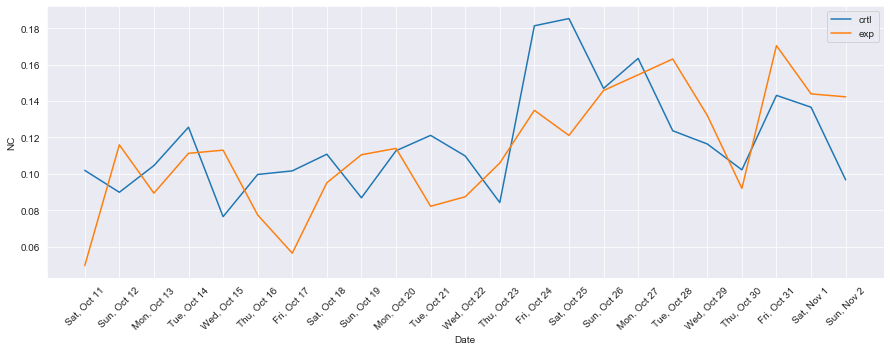

In [33]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='NC', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='NC', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

In [34]:
n_C_NC = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
x_C_NC = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Payments'].sum()
P_C_NC = x_C_NC / n_C_NC
P_C_NC

0.11756201931417337

In [35]:
n_T_NC = Data_exp[Data_ctrl['Enrollments'].notnull()]['Clicks'].sum()
x_T_NC = Data_exp[Data_ctrl['Enrollments'].notnull()]['Payments'].sum()
P_T_NC = x_T_NC / n_T_NC
P_T_NC

0.1126882966396292

In [36]:
d_NC = P_T_NC - P_C_NC
d_NC

-0.0048737226745441675

In [37]:
P_pool_NC = (x_C_NC + x_T_NC) / (n_C_NC + n_T_NC)
P_pool_NC

0.1151274853124186

In [38]:
se_pool_NC = np.sqrt(P_pool_NC*(1 - P_pool_NC)*(1/n_C_NC + 1/n_T_NC))
se_pool_NC

0.0034341335129324238

In [39]:
CI_low_NC = d_NC - 1.96*se_pool_NC
CI_high_NC = d_NC + 1.96*se_pool_NC
print ('95% CI:', (CI_low_NC, CI_high_NC))

95% CI: (-0.011604624359891718, 0.001857179010803383)


- As shown above, the 95% CI contains "0", which means that there no significant different between the control and experiment group on NC.
- This is kinda good, because we don't want this change to affect too much of our income, even we expected the amount of enrollments to drop.

## 2.2 Primary Analysis

In [40]:
Data_ctrl['R'] = Data_ctrl['Payments'] / Data_ctrl['Enrollments']
Data_exp['R'] = Data_exp['Payments'] / Data_exp['Enrollments']

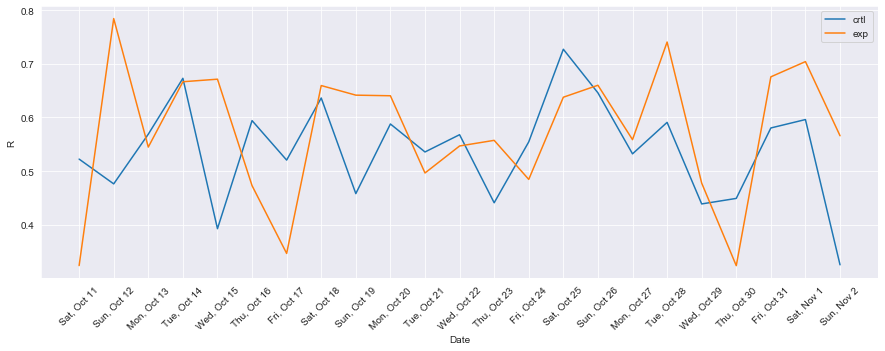

In [41]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='R', data=Data_ctrl[Data_ctrl['Clicks'].notnull()], label='crtl', sort=False)
sns.lineplot(x='Date', y='R', data=Data_exp[Data_ctrl['Clicks'].notnull()], label='exp', sort=False)
plt.xticks(rotation='45')
plt.legend()
plt.show()

$$
\hat{d} = \hat{P}_{T} - \hat{P}_{C}
\hat{P}_C = \dfrac{x_C}{n_C} , \ \hat{P}_T = \dfrac{x_T}{n_T} \\
\ se_{pool} = \sqrt{\hat{P}_{pool}(1-\hat{P}_{pool})(\dfrac{1}{n_C}+\dfrac{1}{n_T})} \\
\hat{P}_{pool} = \dfrac{x_C+x_T}{n_C+n_T} \\
n_C: \text{num of enrollments in control group} \\
n_T: \text{num of enrollments in experiment group} \\
x_C: \text{num of payments in control group} \\
x_T: \text{num of payments in experiment group} \\
\text{then 95% CI:} \ \ \ \hat{d} \pm 1.96 \cdot se_{pool}
$$

$$
\text{Under} \ H_0: \ \ \ \hat{d}_0 \sim N(0, se_{pool}) 
$$

In [42]:
n_C = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
x_C = Data_ctrl[Data_ctrl['Enrollments'].notnull()]['Payments'].sum()
P_C = x_C / n_C
P_C

0.537120211360634

In [43]:
n_T = Data_exp[Data_ctrl['Enrollments'].notnull()]['Enrollments'].sum()
x_T = Data_exp[Data_ctrl['Enrollments'].notnull()]['Payments'].sum()
P_T = x_T / n_T
P_T

0.5682150160677768

In [44]:
d = P_T - P_C
d

0.031094804707142765

In [45]:
P_pool = (x_C + x_T) / (n_C + n_T)
P_pool

0.5518867924528302

In [46]:
se_pool = np.sqrt(P_pool*(1 - P_pool)*(1/n_C + 1/n_T))
se_pool

0.011729780091389183

In [47]:
CI_low = d - 1.96*se_pool
CI_high = d + 1.96*se_pool
print ('95% CI:', (CI_low, CI_high))

95% CI: (0.008104435728019967, 0.05408517368626556)


- As shown above, the 95% CI does not contain "0", which means __the Retention of the experiment group is significantly higher than that of the control group__.
- However, the minimal meaningful worthwhile effect (DA) for Retention is 0.1, which is within this CI.
- Therefore, we might need more samples to get a more precise estimate.

## 2.3 Wilcoxon Signed-Rank Test

- Non-parametric hypothesis testing using __day-by-day data__.
- Wilcoxon Signed-Rank test is the non-parametric equivalent of paired-t test.
- Assumes an underlying continuous symmetric distribution.
- Normal approximation is used (n >= 16).

\begin{align}
&H_0: \text{the median difference between the two groups is zero} \\
&H_1: \text{the median difference between the two groups is not zero}
\end{align}

In [57]:
from scipy.stats import wilcoxon

In [64]:
wilcoxon(x=Data_ctrl[Data_ctrl['Enrollments'].notnull()]['R'],
        y=Data_exp[Data_exp['Enrollments'].notnull()]['R'],
        zero_method='wilcox', alternative='two-sided')

WilcoxonResult(statistic=107.0, pvalue=0.3457507008948919)

- As the resulting p-value shown above, using a significant level of 0.05, we could not reject the null and conclude that the median difference of Retention between the two groups is zero.
- This is inconsistant with the result we got from __2.2__.
- One reason could be that non-parametric methods are generally less powerful than parametric methods.
- Another reason could be that we only have 23 days of observation. As similar suggestion given from __2.2__, we need more samples to get enough power.

# 3 Discussion

- As written in the description, the purpose of making this change is to reduce the number of frustrated students who left the free trial early. Since using "Retention" as the KPI requires a large sample size and relatively long duration, we might need to discover other metrics that can also reflect related change we are expecting.
- Even this change is said to increase students' learning experience, the main purpose is to let the students like this websites so that more people would enroll to the course and altimately increase the income, which is a long term effect to check.
- Another metric we can check is the probability of users who return to enroll into more courses after taking one, which could reflect our purpose of income increasing more closely.